# BTCデータのCSVファイル読み込み
事前に1hのcsvデータをdataディレクトリに格納しておくこと

In [3]:
import pandas as pd

file_path = './data/BTC_ohlcv_binance_1h.csv'
df = pd.read_csv(file_path)

df.head()

,timestamp,open,high,low,close,volume
0,1609459200000,28923.63,29031.34,28690.17,28995.13,2311.811445
1,1609462800000,28995.13,29470.00,28960.35,29409.99,5403.068471
2,1609466400000,29410.00,29465.26,29120.03,29194.65,2384.231560
3,1609470000000,29195.25,29367.00,29150.02,29278.40,1461.345077
4,1609473600000,29278.41,29395.00,29029.40,29220.31,2038.046803


# データの前処理

## 欠損の扱い
Binanceのシステム障害等の影響で、1hデータが欠損していることがある。  
よって、1hごとにリサンプルして行レベルの欠損を補完する。
ただし、価格やvolumeについて算出するのは控え、NaNのままにしておく（学習直前に消す）

In [4]:
import numpy as np

# datetime列を追加（timestampから算出）
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)

# datetime列をindexとし、1h毎のデータにする
df_resample = df.set_index('datetime').resample('1h').asfreq()
df_resample.head()

# timestamp全体をdatetimeから算出しセットしなおす
df_resample['timestamp'] = df_resample.index.map(
    lambda x: int(x.timestamp() * 1000)
)

# volumeが低すぎるデータは異常値としてNaNにする
min_vol = 10
print(df_resample.loc[df_resample['volume'] <= min_vol, 'volume'] )
df_resample.loc[df_resample['volume'] <= min_vol, 'volume'] = np.nan


# 欠損を含む行の確認
df_resample[df_resample.isnull().any(axis=1)]

datetime
2021-02-11 03:00:00+00:00    0.000000
2021-04-25 04:00:00+00:00    5.887034
2023-03-24 12:00:00+00:00    0.000000
Name: volume, dtype: float64


,timestamp,open,high,low,close,volume
datetime,,,,,,
2021-02-11 03:00:00+00:00,1613012400000,44582.07,44582.07,44582.07,44582.07,NaN
2021-02-11 04:00:00+00:00,1613016000000,NaN,NaN,NaN,NaN,NaN
2021-03-06 02:00:00+00:00,1614996000000,NaN,NaN,NaN,NaN,NaN
2021-04-20 02:00:00+00:00,1618884000000,NaN,NaN,NaN,NaN,NaN
2021-04-20 03:00:00+00:00,1618887600000,NaN,NaN,NaN,NaN,NaN
2021-04-25 04:00:00+00:00,1619323200000,49626.76,49705.04,49600.24,49683.94,NaN
2021-04-25 05:00:00+00:00,1619326800000,NaN,NaN,NaN,NaN,NaN
2021-04-25 06:00:00+00:00,1619330400000,NaN,NaN,NaN,NaN,NaN
2021-04-25 07:00:00+00:00,1619334000000,NaN,NaN,NaN,NaN,NaN


# 特徴量の追加１（曜日、休・祝日）
*   曜日の追加（ダミー変数化）
*   祝日か否かの追加
*   休日か否か（土日もしくは祝日）の追加



In [5]:
import holidays

df_feat1 = df_resample.copy()

# ----------------------------
# 曜日の追加
# ----------------------------
# day列を追加
day_names = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
df_feat1['day'] = df_feat1.index.dayofweek.map(lambda x: day_names[x])

# dayをダミー変数化
day = pd.get_dummies(df_feat1["day"], drop_first=True, dtype=int)
df_feat1 = pd.concat([df_feat1, day], axis=1).drop("day", axis=1)


# ----------------------------
# 祝日（is_holiday）の追加
# ----------------------------
# dfに存在する"年"のリストを作成する
years = df_feat1.index.year.unique().tolist()
print(f"{years=}")

# アメリカの祝日を取得
us_holidays = holidays.UnitedStates(years=years)
print(f"{us_holidays=}")

# 特徴量の追加　祝日 (1: 祝日, 0: 平日)
df_feat1['is_holiday'] = df_feat1.index.map(lambda x: 1 if x in us_holidays else 0)


# ----------------------------
# 休日の追加（is_off_day）
# ----------------------------
df_feat1['is_off_day'] = df_feat1[['sat', 'sun', 'is_holiday']].any(axis=1).astype(int)


df_feat1

years=[2021, 2022, 2023, 2024, 2025, 2026]
us_holidays={datetime.date(2021, 1, 1): "New Year's Day", datetime.date(2021, 12, 31): "New Year's Day (observed)", datetime.date(2021, 5, 31): 'Memorial Day', datetime.date(2021, 6, 19): 'Juneteenth National Independence Day', datetime.date(2021, 6, 18): 'Juneteenth National Independence Day (observed)', datetime.date(2021, 7, 4): 'Independence Day', datetime.date(2021, 7, 5): 'Independence Day (observed)', datetime.date(2021, 9, 6): 'Labor Day', datetime.date(2021, 11, 25): 'Thanksgiving Day', datetime.date(2021, 12, 25): 'Christmas Day', datetime.date(2021, 12, 24): 'Christmas Day (observed)', datetime.date(2021, 1, 18): 'Martin Luther King Jr. Day', datetime.date(2021, 2, 15): "Washington's Birthday", datetime.date(2021, 10, 11): 'Columbus Day', datetime.date(2021, 11, 11): 'Veterans Day', datetime.date(2022, 1, 1): "New Year's Day", datetime.date(2022, 5, 30): 'Memorial Day', datetime.date(2022, 6, 19): 'Juneteenth National Independence D

,timestamp,open,high,low,close,volume,mon,sat,sun,thu,tue,wed,is_holiday,is_off_day
datetime,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,1609459200000,28923.63,29031.34,28690.17,28995.13,2311.811445,0,0,0,0,0,0,1,1
2021-01-01 01:00:00+00:00,1609462800000,28995.13,29470.00,28960.35,29409.99,5403.068471,0,0,0,0,0,0,1,1
2021-01-01 02:00:00+00:00,1609466400000,29410.00,29465.26,29120.03,29194.65,2384.231560,0,0,0,0,0,0,1,1
2021-01-01 03:00:00+00:00,1609470000000,29195.25,29367.00,29150.02,29278.40,1461.345077,0,0,0,0,0,0,1,1
2021-01-01 04:00:00+00:00,1609473600000,29278.41,29395.00,29029.40,29220.31,2038.046803,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-31 22:00:00+00:00,1767218400000,87799.97,87879.04,87656.19,87728.29,236.186970,0,0,0,0,0,1,0,0
2025-12-31 23:00:00+00:00,1767222000000,87728.30,87728.30,87619.67,87648.22,191.191230,0,0,0,0,0,1,0,0
2026-01-01 00:00:00+00:00,1767225600000,87648.21,87849.26,87632.74,87809.23,233.660360,0,0,0,1,0,0,1,1


#

# 特徴量の追加2（価格変化、リスクなど）


*   ret_1h ・・・ <超短期>	直近1時間の対数収益率（勢いの変化を察知）
*   ret_2h ・・・ <超短期>	直近2時間の対数収益率（加速・減速の判定）
*   ret_4h ・・・ <中期>	直近4時間の対数収益率（ターゲット期間と同等のトレンド）
*   ret_12h ・・・ <中期>	直近12時間の対数収益率（半日間の地合い）
*   ret_24h ・・・ <長期>	直近24時間の対数収益率（1日のトレンド）
*   vola_4h ・・・ <リスク>	直近4時間の標準偏差（今の荒れ具合）
*   vola_24h ・・・ <リスク>	直近24時間の標準偏差（全体のボラティリティ）
*   vol_ratio_24h ・・・ <出来高>	直近1h出来高 / 直近24h平均出来高（盛り上がりの相対化）
*   bias_24h ・・・ <乖離率>	現在値と24h移動平均の乖離（買われすぎ・売られすぎ）


In [6]:
import numpy as np
df_feat2 = df_feat1.copy()

# ｎ時間前からのリターン（対数収益率）
for n in [1, 2, 4, 12, 24]:
  df_feat2[f'log_ret_{n}h'] = np.log(df_feat2['close'] / df_feat2['close'].shift(n))

# ｎ時間のボラティリティ
for n in [4, 24]:
  df_feat2[f'vola_{n}h'] = df_feat2['log_ret_1h'].rolling(n).std()

# 出来高比率
vol_mean24 = df_feat2['volume'].rolling(24).mean()
df_feat2['vol_ratio_24h'] = (df_feat2['volume'] - vol_mean24) / vol_mean24

# 24h移動平均との乖離
sma_24 = df_feat2['close'].rolling(24).mean()
df_feat2['bias_24h'] = (df_feat2['close'] - sma_24) / sma_24


df_feat2.loc[: , 'log_ret_1h':]

,log_ret_1h,log_ret_2h,log_ret_4h,log_ret_12h,log_ret_24h,vola_4h,vola_24h,vol_ratio_24h,bias_24h
datetime,,,,,,,,,
2021-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00+00:00,0.014207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00+00:00,-0.007349,0.006858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 03:00:00+00:00,0.002865,-0.004484,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 04:00:00+00:00,-0.001986,0.000879,0.007736,NaN,NaN,0.009184,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-12-31 22:00:00+00:00,-0.000817,0.000756,0.000504,-0.012674,-0.007969,0.001591,0.002610,-0.512937,-0.006512
2025-12-31 23:00:00+00:00,-0.000913,-0.001730,0.001214,-0.015434,-0.009507,0.001352,0.002604,-0.603016,-0.007027
2026-01-01 00:00:00+00:00,0.001835,0.000922,0.001678,-0.010949,-0.005070,0.001488,0.002599,-0.514402,-0.004993


# 正解データの追加

In [7]:
df_target = df_feat2.copy()

# 4時間後にどれだけ価格変化したかを対数収益率でセット
# df_target['log_ret_after_4h'] = np.log(df_target['close'].shift(-4) / df_target['close'])
# df_target[['timestamp', 'close', 'log_ret_after_4h']].head()
def classify_target(ret):
    if ret >= 0.3:
        return 3
    elif ret <= -0.3:
        return 1
    else:
        return 2

df_target['pct_ret_after_4h'] = (df_target['close'].shift(-4) - df_target['close']) * 100 / df_target['close']
df_target['target'] = df_target['pct_ret_after_4h'].apply(classify_target)
df_target[['timestamp', 'close', 'pct_ret_after_4h', 'target']].head()

,timestamp,close,pct_ret_after_4h,target
datetime,,,,
2021-01-01 00:00:00+00:00,1609459200000,28995.13,0.776613,3
2021-01-01 01:00:00+00:00,1609462800000,29409.99,-0.758178,1
2021-01-01 02:00:00+00:00,1609466400000,29194.65,-0.069533,2
2021-01-01 03:00:00+00:00,1609470000000,29278.40,-0.633812,1
2021-01-01 04:00:00+00:00,1609473600000,29220.31,-0.753928,1


# 欠損行の削除
欠損値は穴埋めするのではなく削除する

In [8]:
# 欠損値を含む行を削除
df_final = df_target.dropna()

print(f'削除前: {len(df_target)}  削除後: {len(df_final)}  削除件数: {len(df_target) - len(df_final)}')

削除前: 43827  削除後: 43600  削除件数: 227


# モデルの作成・評価

## データの分割

In [9]:
from sklearn.model_selection import train_test_split

# 訓練・学習の分割
feature_cols = [
    'mon', 'sat', 'sun', 'thu', 'tue', 'wed', 'is_holiday', 'is_off_day',
    'log_ret_1h', 'log_ret_2h', 'log_ret_4h', 'log_ret_12h', 'log_ret_24h',
    'vola_4h', 'vola_24h', 'vol_ratio_24h', 'bias_24h'
]

X_train, X_test, y_train, y_test = train_test_split(
    df_final[feature_cols],
    df_final['target'],
    test_size=0.2,
    shuffle=False
)

print(f"訓練データ: {len(X_train)}件 ({X_train.index.min()} - {X_train.index.max()})")
print(f"テストデータ: {len(X_test)}件 ({X_test.index.min()} - {X_test.index.max()})")

訓練データ: 34880件 (2021-01-02 00:00:00+00:00 - 2025-01-02 14:00:00+00:00)
テストデータ: 8720件 (2025-01-02 15:00:00+00:00 - 2025-12-31 22:00:00+00:00)



## 決定木

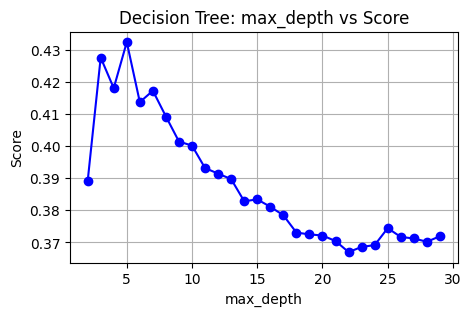

high_score=0.4323394495412844 high_score_depth=5


In [10]:
import matplotlib.pyplot as plt
from sklearn import tree

depths = []
scores = []
high_score = 0
high_score_depth = 0

for depth in range(2, 30):
  model = tree.DecisionTreeClassifier(max_depth=depth, random_state=0, class_weight='balanced')
  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)
  depths.append(depth)
  scores.append(score)
  if score >= high_score:
    high_score = score
    high_score_depth = depth

plt.figure(figsize=(5, 3))
plt.plot(depths, scores, marker='o', linestyle='-', color='b')
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.title('Decision Tree: max_depth vs Score')
plt.grid(True)
plt.show()
print(f"{high_score=} {high_score_depth=}")

In [11]:
import pickle

# 全データ学習版
X = df_final[feature_cols]
y = df_final['target']
print(f"学習データ: {len(df_final)}件")

model = tree.DecisionTreeClassifier(max_depth=3, random_state=0, class_weight='balanced')
model.fit(X, y)

# with open('../models/decision_tree.pkl', 'wb') as f:
#     pickle.dump(model, f)

model.score(X_test, y_test)  # 念のためスコア確認

学習データ: 43600件


0.41926605504587156

## 

In [12]:
pd.DataFrame(model.feature_importances_, index=X.columns)

,0
mon,0.000000
sat,0.143832
sun,0.000000
thu,0.000000
tue,0.000000
wed,0.000000
is_holiday,0.000000
is_off_day,0.000000
log_ret_1h,0.000000
log_ret_2h,0.000000


## ロジスティック回帰

In [13]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

model_lr = LogisticRegression(
    solver='lbfgs', 
    max_iter=1000, 
    class_weight='balanced',
    random_state=0
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols)

model_lr.fit(X_train_scaled_df, y_train)
score = model.score(X_test_scaled_df, y_test)
print(f"{score=}")

score=0.4230504587155963


In [ ]:
import pickle

# 全データ学習版
X = df_final[feature_cols]
y = df_final['target']
print(f"学習データ: {len(df_final)}件")

model_lr = LogisticRegression(
    solver='lbfgs', 
    max_iter=1000, 
    class_weight='balanced',
    random_state=0
)

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

# 学習
model_lr.fit(X_scaled_df, y)
score = model_lr.score(X_test_scaled_df, y_test)
print(f"{score=}")

# モデル保存
# with open('../models/logistic_regression_sc.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

# with open('../models/logistic_regression.pkl', 'wb') as f:
#     pickle.dump(model_lr, f)

学習データ: 43600件
score=0.44311926605504587


## ランダムフォレスト

In [15]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

# estimators = []
# scores = []
# high_score = 0
# high_score_estimators = 0

# for n in range(71, 90):
#     # 1. モデルの作成
#     model_rf = RandomForestClassifier(
#         n_estimators=n,
#         max_depth=4,
#         random_state=0,
#         class_weight='balanced'
#     )
#     model_rf.fit(X_train, y_train)
#     score = model_rf.score(X_test, y_test)
#     estimators.append(n)
#     scores.append(score)
#     print(f"{n=} {score=}")
#     if score >= high_score:
#         high_score = score
#         high_score_estimators = n

# plt.figure(figsize=(5, 3))
# plt.plot(estimators, scores, marker='o', linestyle='-', color='b')
# plt.xlabel('estimators')
# plt.ylabel('Score')
# plt.title('Decision Tree: estimators vs Score')
# plt.grid(True)
# plt.show()
# print(f"{high_score=} {high_score_estimators=}")

# めぼしいn_estimators
# n=1 score=0.43153669724770644
# n=11 score=0.42958715596330277
# n=16 score=0.42970183486238533
# n=37 score=0.42958715596330277
# n=39 score=0.43027522935779816
# n=40 score=0.4294724770642202
# n=41 score=0.4290137614678899

In [16]:
# from sklearn.ensemble import RandomForestClassifier

# estimators = [1, 11, 16, 37, 39, 40, 41]
# for n in estimators:
#     for d in range(1, 10):
#         # 1. モデルの作成
#         model_rf = RandomForestClassifier(
#             n_estimators=n,
#             max_depth=d,
#             random_state=0,
#             class_weight='balanced'
#         )
#         model_rf.fit(X_train, y_train)
#         score = model_rf.score(X_test, y_test)
#         print(f"{n=} {d=}: {score=}")

# n=1	d=4		score=0.43153669724770644
# n=37	d=9		score=0.43153669724770644 ★ これに決定
# n=40	d=3		score=0.4313073394495413
# n=39	d=3		score=0.4307339449541284
# n=11	d=7		score=0.4303899082568807


In [17]:
from sklearn.ensemble import RandomForestClassifier
import pickle

# 全データ学習版
X = df_final[feature_cols]
y = df_final['target']
print(f"学習データ: {len(df_final)}件")

model_rf = RandomForestClassifier(
    n_estimators=37,
    max_depth=9,
    random_state=0,
    class_weight='balanced'
)
model_rf.fit(X, y)

# with open('../models/random_forest.pkl', 'wb') as f:
#     pickle.dump(model_rf, f)

model_rf.score(X_test, y_test)  # 念のためスコア確認

学習データ: 43600件


0.5330275229357798

In [22]:
# 2025のみ学習したモデルを作る

from sklearn.ensemble import RandomForestClassifier
import pickle

# 全データ学習版
df_final_2025 = df_final[df_final["timestamp"] >= 1735689600000]
X = df_final_2025[feature_cols]
y = df_final_2025['target']
print(f"学習データ: {len(df_final_2025)}件")

model_rf = RandomForestClassifier(
    n_estimators=37,
    max_depth=9,
    random_state=0,
    class_weight='balanced'
)
model_rf.fit(X, y)

with open('../models/random_forest_2025.pkl', 'wb') as f:
    pickle.dump(model_rf, f)

model_rf.score(X_test, y_test)  # 念のためスコア確認

学習データ: 8759件


0.6647935779816514